In [1]:
import iminuit
# import probfit
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import scipy as sp
from scipy import optimize
from scipy import stats
import cProfile, pstats, StringIO
from multiprocessing import Pool
import pandas as pd
import pymp
from __future__ import print_function
import copy

import atm_c14_data
import c14_models
import c14_individuals_data
import os

%load_ext ipycache

reload(atm_c14_data)
reload(c14_models)
reload(c14_individuals_data);

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
exec(open('settings.py').read(), globals())

def CI(M, p):
    value = M.values[p]
    lower = M.get_merrors()[p]['lower']
    upper = M.get_merrors()[p]['upper']
    return value + lower, value + upper

atm_c14_data.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  c14_data = c14_data.sort('year')
/home/fabian/anaconda2/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/fabian/anaconda2/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/home/fabian/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
Klag = atm_c14_data.Klag
K = atm_c14_data.K
C = c14_models.C_scenario_A
C2 = c14_models.C_scenario_2POP

c14_i_data = c14_individuals_data.c14_neu

c14_i_data_sigma = c14_i_data[ c14_i_data['Dbirth'] <= 1955.5 ]
sigma_estimate = c14_i_data_sigma['d14C'].std()

Assign colors to samples, sorted by year

In [3]:
colornumber = sp.empty(len(c14_i_data), dtype = int)
for i, index in enumerate(c14_i_data.sort_values('Dbirth').index):
    colornumber[index - 1] = i % len(colorcycle)
c14_i_data['color'] = map(lambda i: colorcycle[i], colornumber)

/home/fabian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Scenario A

### Constant sigma

In [4]:
def neg_loglike_A(r, sigma):
    loglike = 0
    for i, dataset in c14_i_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C(Dbirth, Dcoll, r)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [5]:
M_A = iminuit.Minuit(neg_loglike_A, errordef = 0.5,\
           r = 0.0066, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
           sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
           print_level = 1)
M_A.migrad();

FCN = -82.0943766494 
 TOTAL NCALL = 53 
 NCALLS = 53 
 
 
 EDM = 1.45109070986e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,5.544954e-03,7.693913e-04,0.000000e+00,0.000000e+00,0.0,,
2,sigma,5.439091e-02,5.185443e-03,0.000000e+00,0.000000e+00,0.0,,


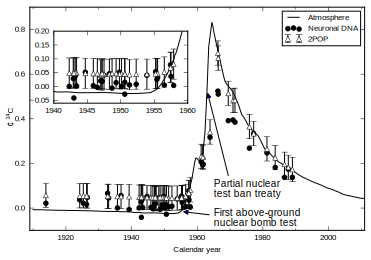

In [71]:
f, ax = plt.subplots(1, 1, figsize = (6, 4))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(c14_i_data['Dbirth'], c14_i_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
ax.errorbar(c14_i_data['Dbirth'], \
           sp.vectorize(C)(c14_i_data['Dbirth'], c14_i_data['Dcoll'], M_A.values['r']), M_A.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
# ax.grid(which='both')
ax.legend(loc='best')

ax.set_xlabel('Calendar year')
ax.set_ylabel('$\Delta^{14}$C')

ax.annotate("First above-ground\nnuclear bomb test", xy = (1955, K(1955)), xytext = (1965, -0.08),
            arrowprops = dict(arrowstyle = '-|>'))
ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, K(1963)), xytext = (1965, 0.05),
            arrowprops = dict(arrowstyle = '-|>'))

axins = inset_axes(ax,
                   width="40%",  # width = 30% of parent_bbox
                   height=1.,  # height : 1 inch
                   loc=2, borderpad = 3)

axins.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
axins.scatter(c14_i_data['Dbirth'], c14_i_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
axins.errorbar(c14_i_data['Dbirth'], \
           sp.vectorize(C)(c14_i_data['Dbirth'], c14_i_data['Dcoll'], M_A.values['r']), M_A.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

axins.set_xlim(1940, 1960)
axins.set_ylim(-0.06, 0.2)

plt.savefig('c14_predict_A.svg')

plt.show()

In [7]:
M_A.minos(sigma = 1.92);

Error,-0.001436704145,0.00158800907362
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.00861909641917,0.0117099986073
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [8]:
CI(M_A, 'r')

(0.004108249373082076, 0.007132962591703897)

In [9]:
CI(M_A, 'sigma')

(0.04577181214223788, 0.06610090716868489)

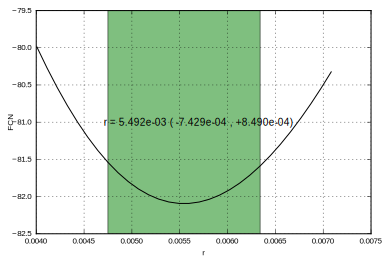

In [10]:
M_A.draw_mnprofile('r');

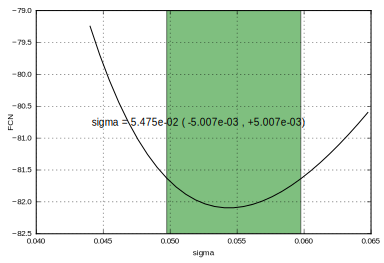

In [11]:
M_A.draw_mnprofile('sigma');

### Sigma dependent on mass of sample

In [12]:
def neg_loglike_A_mass(r, sigma_light, sigma_heavy):
    loglike = 0
    for i, dataset in c14_i_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C(Dbirth, Dcoll, r)
        if dataset['mass'] < 10.0:
            sigma = sigma_light
        else:
            sigma = sigma_heavy
        
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [13]:
M_A_mass = iminuit.Minuit(neg_loglike_A_mass, errordef = 0.5,\
                          r = 0.0066, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                          sigma_light = sigma_estimate, error_sigma_light = sigma_estimate / 10.0,
                          limit_sigma_light = (0.0, None), fix_sigma_light = False,
                          sigma_heavy = sigma_estimate, error_sigma_heavy = sigma_estimate / 10.0,
                          limit_sigma_heavy = (0.0, None), fix_sigma_heavy = False,
                          print_level = 1)

In [14]:
M_A_mass.migrad();

FCN = -82.0959516923 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 3.71665083347e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,5.535547e-03,7.870723e-04,0.000000e+00,0.000000e+00,0.0,,
2,sigma_light,5.361449e-02,1.461596e-02,0.000000e+00,0.000000e+00,0.0,,
3,sigma_heavy,5.450396e-02,5.578983e-03,0.000000e+00,0.000000e+00,0.0,,


## 2POP

In [15]:
def neg_loglike_2POP(r, f, sigma):
    loglike = 0
    for i, dataset in c14_i_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C2(Dbirth, Dcoll, r, f)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [16]:
M_2POP = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = 0.12, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 1)

In [17]:
M_2POP.migrad();

FCN = -115.222983366 
 TOTAL NCALL = 121 
 NCALLS = 121 
 
 
 EDM = 3.97590287622e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,2.277187e-01,8.951309e-02,0.000000e+00,0.000000e+00,0.0,,
2,f,3.409061e-01,1.775861e-02,0.000000e+00,0.000000e+00,0.0,1.0,
3,sigma,2.978068e-02,2.839322e-03,0.000000e+00,0.000000e+00,0.0,,


In [19]:
for color, group in c14_i_data.groupby('color'):
    break

In [20]:
group

,type,pub_id,Dbirth,Dcoll,d14C,mass,color
21,neuronal nuclei (NeuN+),34.0,1945.9,2010.8,0.003278,9.308333,"(0.0, 0.0, 0.0)"
25,neuronal nuclei (NeuN+),38.0,1949.3,2008.1,0.014215,26.820000,"(0.0, 0.0, 0.0)"
33,neuronal nuclei (NeuN+),49.0,1961.7,2010.2,0.193400,44.666667,"(0.0, 0.0, 0.0)"
34,neuronal nuclei (NeuN+),50.0,1955.2,2010.3,0.053600,25.600000,"(0.0, 0.0, 0.0)"
42,neuronal nuclei (NeuN+),62.0,1975.9,2007.4,0.268490,30.000000,"(0.0, 0.0, 0.0)"
45,neuronal nuclei (NeuN+),67.0,1936.8,2011.3,0.056180,6.300000,"(0.0, 0.0, 0.0)"
54,neuronal nuclei (NeuN+),79.0,1913.9,2005.8,0.021639,35.000000,"(0.0, 0.0, 0.0)"


In [21]:
inset_axes?

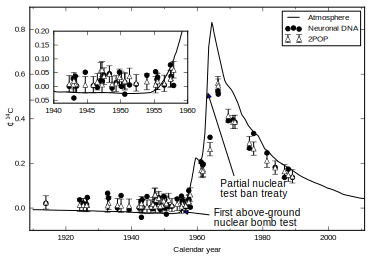

In [76]:
f, ax = plt.subplots(1, 1, figsize = (6, 4))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(c14_i_data['Dbirth'], c14_i_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
ax.errorbar(c14_i_data['Dbirth'], \
           sp.vectorize(C2)(c14_i_data['Dbirth'], c14_i_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
            M_2POP.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
# ax.grid(which='both')
ax.legend(loc='best')

ax.set_xlabel('Calendar year')
ax.set_ylabel('$\Delta^{14}$C')

ax.annotate("First above-ground\nnuclear bomb test", xy = (1955, K(1955)), xytext = (1965, -0.08),
            arrowprops = dict(arrowstyle = '-|>'))
ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, K(1963)), xytext = (1967, 0.05),
            arrowprops = dict(arrowstyle = '-|>'))

axins = inset_axes(ax,
                   width="40%",  # width = 30% of parent_bbox
                   height=1.,  # height : 1 inch
                   loc=2, borderpad = 3)

axins.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
axins.scatter(c14_i_data['Dbirth'], c14_i_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
axins.errorbar(c14_i_data['Dbirth'], \
           sp.vectorize(C2)(c14_i_data['Dbirth'], c14_i_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
            M_2POP.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

axins.set_xlim(1940, 1960)
axins.set_ylim(-0.06, 0.2)

exportname = 'c14_predict_2POP'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))

plt.show()

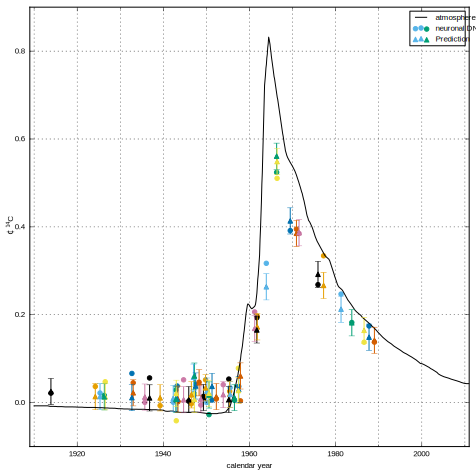

In [23]:
f, ax = plt.subplots(1, 1, figsize = (200 / 25.4, 200 / 25.4))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'atmosphere')
ax.scatter(c14_i_data['Dbirth'], c14_i_data['d14C'], label = 'neuronal DNA', color = c14_i_data['color'])
for color, group in c14_i_data.groupby('color'):
    ax.errorbar(group['Dbirth'], 
               sp.vectorize(C2)(group['Dbirth'], group['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
                M_2POP.values['sigma'],
                marker='^', ls = '', color = color)
ax.scatter(c14_i_data['Dbirth'], 
           sp.vectorize(C2)(c14_i_data['Dbirth'], c14_i_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),
           marker = '^', color = c14_i_data['color'], label = 'Prediction', zorder = 100)


ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
ax.grid(which='both')
ax.legend(loc='best')

ax.set_xlabel('calendar year')
ax.set_ylabel('$\Delta^{14}$C')

# plt.savefig('fit_2POP_neu.png', dpi = 300, bbox_inches='tight', transparent = True)
plt.show()

In [24]:
M_2POP.minos(sigma = 1.92);

Error,-0.0986781555538,0.0895130893125
Valid,True,False
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0348050653263,0.034814343781
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


/home/fabian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        r = +nan
        f = +0.340917
    sigma = +0.025163

  if __name__ == '__main__':
/home/fabian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        r = -nan
        f = -nan
    sigma = +0.025163

  if __name__ == '__main__':


Error,-0.00471925098747,0.00641153874005
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [25]:
CI(M_2POP, 'f')

(0.30610101795690237, 0.3757204270641477)

In [26]:
CI(M_2POP, 'sigma')

(0.025061431627204277, 0.03619222135472308)

/home/fabian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for f=0.332333
  if __name__ == '__main__':


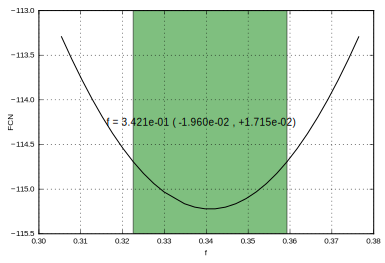

In [27]:
M_2POP.draw_mnprofile('f');

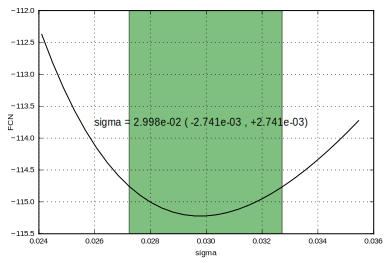

In [28]:
M_2POP.draw_mnprofile('sigma');

Manual profile likelihood for $r$ as `minos` didn't work.

In [29]:
%%cache rprofile.pkl rs neglogL
rs = sp.sort(sp.hstack((sp.linspace(0.1, 10, 50), M_2POP.values['r'], 0.15)))
f_initial = M_2POP.values['f']
sigma_initial = M_2POP.values['sigma']
def fit_fix_r(r):
    M_2POP = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = r, error_r = 1e-3, limit_r = (0.0, None), fix_r = True,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP.migrad()
    if M_2POP.migrad_ok():
        return M_2POP.fval
    else:
        return sp.nan

pool = Pool(processes=4) 

neglogL = sp.array(pool.map(fit_fix_r, rs))

[Skipped the cell's code and loaded variables neglogL, rs from file '/media/500G/fabian/work/C14/birth_death_implementation/C14_github/rprofile.pkl'.]


In [30]:
f = sp.interpolate.interp1d(rs, neglogL - neglogL.min() - 1.92) 

In [31]:
from scipy import optimize
rmin = sp.optimize.root(f, 0.1, method='lm')['x'].item()
rmax = sp.optimize.root(f, 2, method='lm')['x'].item()

print('r:')
print('{0:.2f} (95\% CI [{1:.2f}, {2:.2f}])'.format(M_2POP.values['r'], rmin, rmax))


r:
0.23 (95\% CI [0.14, 3.83])


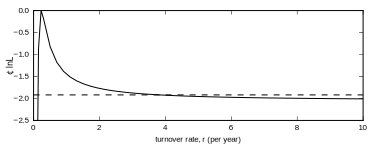

In [32]:
fig = plt.figure(figsize= (150 / 25.4, 50 / 25.4) )
plt.xlim(0, 10)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

plt.plot(rs, -(neglogL-M_2POP.fval), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

exportname = 'rprofile'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))

plt.show()

## 2POP mass

In [33]:
def neg_loglike_2POP_mass(r, f, sigma_light, sigma_heavy):
    loglike = 0
    for i, row in c14_i_data.iterrows():
        Dbirth = row['Dbirth']
        Dcoll = row['Dcoll']
        Cexp = row['d14C']
        Cmodel = C2(Dbirth, Dcoll, r, f)
        if row['mass'] < 10.0:
            sigma = sigma_light
        else:
            sigma = sigma_heavy
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [34]:
M_2POP_mass = iminuit.Minuit(neg_loglike_2POP_mass, errordef = 0.5,\
                   r = 0.12, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma_light = sigma_estimate*20, error_sigma_light = sigma_estimate / 10.0, limit_sigma_light = (0.0, None), fix_sigma_light = False,
                   sigma_heavy = sigma_estimate, error_sigma_heavy = sigma_estimate / 10.0, limit_sigma_heavy = (0.0, None), fix_sigma_heavy = False,\
                   print_level = 1)

In [35]:
M_2POP_mass.migrad();

FCN = -115.225987378 
 TOTAL NCALL = 256 
 NCALLS = 256 
 
 
 EDM = 5.4010557966e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,2.286414e-01,8.480698e-02,0.000000e+00,0.000000e+00,0.0,,
2,f,3.407259e-01,1.792855e-02,0.000000e+00,0.000000e+00,0.0,1.0,
3,sigma_light,2.919448e-02,7.927086e-03,0.000000e+00,0.000000e+00,0.0,,
4,sigma_heavy,2.986507e-02,3.055224e-03,0.000000e+00,0.000000e+00,0.0,,
